<a href="https://colab.research.google.com/github/PedroAMtz/Biomedical_Imaging/blob/main/Chest_CT_Scan_images_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple CNN for Chest CT-Scan cancer detection


In this notebook we are going to explore the Chest CT-Scan images Dataset provided in Kaggle platform. This dataset consists of data splitted into 3 folders (train, test and valid) and each of them containing the folders for each class we are trying to predict (4 different classes)

The proposed model is a simple CNN.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, os.path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from zipfile import ZipFile
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


In [3]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 99% 118M/119M [00:04<00:00, 31.9MB/s]
100% 119M/119M [00:04<00:00, 29.0MB/s]


In [4]:
file_name = '/content/chest-ctscan-images.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Extraction done')

Extraction done


**Visualization of the data**

In [5]:
test_root = '/content/Data/test'
train_root = '/content/Data/train'
valid_root = '/content/Data/valid'

In [6]:
def plot_images(main_dir, label=0):

    fnames = os.listdir(main_dir)
    class_1 = os.path.join(main_dir, fnames[label])
    class1_fnames = os.listdir(class_1)

    fig, axs = plt.subplots(nrows=3, ncols=5)
    axs = axs.flatten()

    for i in range(15):
        filepath = os.path.join(class_1, class1_fnames[i])
        img = Image.open(filepath)
        axs[i].imshow(img)
        axs[i].axis('off')
    fig.suptitle('Images from ' + str(fnames[label]))
    plt.show()

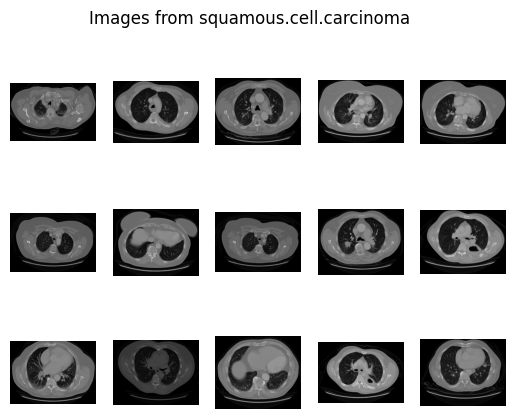

In [8]:
plot_images(test_root, label=3)

**Load data**

In [9]:
def load_data(train_path, test_path, valid_path, img_shape=(256, 256)):

    batch_size = 34
    norm = 1. / 255.0
    train_dg = ImageDataGenerator(rescale=norm)
    test_dg = ImageDataGenerator(rescale=norm)
    valid_dg = ImageDataGenerator(rescale=norm)

    train_generator = train_dg.flow_from_directory(
        train_path,
        target_size=img_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

    val_generator = valid_dg.flow_from_directory(
        valid_path,
        target_size=img_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

    test_generator = test_dg.flow_from_directory(
        test_path,
        target_size=img_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

    return train_generator, test_generator, val_generator

In [10]:
train_data, test_data, valid_data = load_data(train_root, test_root, valid_root);

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


**Helper functions**

In [11]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def confusion_mtx(y_test, y_pred):
  sns.heatmap(confusion_matrix(
  y_test.argmax(axis=1), y_pred.argmax(axis=1)), annot = True, cmap = "rainbow")
  plt.title("Confusion Matrix")
  plt.show()

**Model: Simple CNN**

In [14]:
def build_model(num_classes=4):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same',
                            input_shape= (256,256,3)),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(num_classes, activation='sigmoid')])
  return model

In [15]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       2

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                 loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [17]:
earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)

history = model.fit(train_data,
                    epochs=100, 
                    validation_data=valid_data,
                    verbose = 1,
                    callbacks= earlystop,
                    initial_epoch=0)

Epoch 1/100
19/19 [==============================] - 26s 410ms/step - loss: 2.0360 - accuracy: 0.2659 - val_loss: 1.3837 - val_accuracy: 0.3194
Epoch 2/100
19/19 [==============================] - 7s 360ms/step - loss: 1.3582 - accuracy: 0.3132 - val_loss: 1.3777 - val_accuracy: 0.3194
Epoch 3/100
19/19 [==============================] - 6s 301ms/step - loss: 1.3267 - accuracy: 0.3148 - val_loss: 1.3366 - val_accuracy: 0.4028
Epoch 4/100
19/19 [==============================] - 6s 325ms/step - loss: 1.3107 - accuracy: 0.3850 - val_loss: 1.3216 - val_accuracy: 0.3056
Epoch 5/100
19/19 [==============================] - 6s 306ms/step - loss: 1.2540 - accuracy: 0.3915 - val_loss: 1.2097 - val_accuracy: 0.3889
Epoch 6/100
19/19 [==============================] - 6s 307ms/step - loss: 1.3825 - accuracy: 0.3866 - val_loss: 1.3222 - val_accuracy: 0.3750
Epoch 7/100
19/19 [==============================] - 7s 340ms/step - loss: 1.2374 - accuracy: 0.4323 - val_loss: 1.2533 - val_accuracy: 0.402

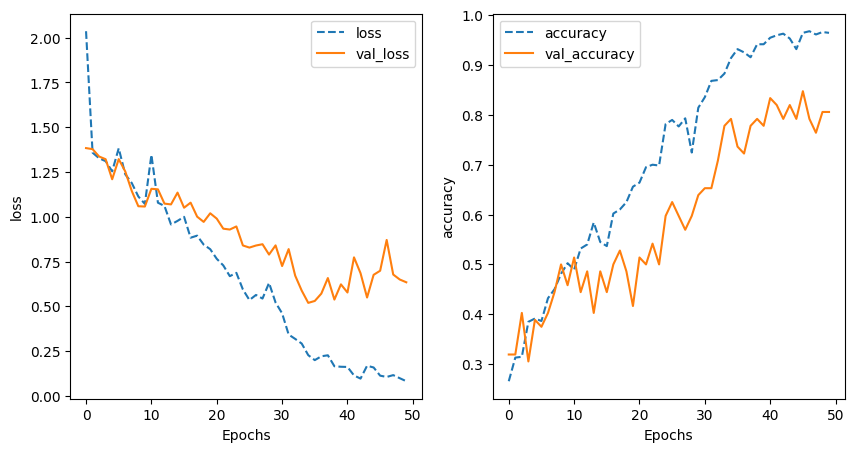

In [18]:
training_plot(['loss', 'accuracy'], history)

In [22]:
model.evaluate(valid_data)

3/3 [==============================] - 1s 172ms/step - loss: 0.5197 - accuracy: 0.7917


[0.519690990447998, 0.7916666865348816]